In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # May improve speed on some CPUs


In [3]:
def read_trc(fpath):
    # read metadata in file header
    df_meta = pd.read_csv(fpath, delimiter='\t', header=0, skiprows=1, nrows=1)
    meta = df_meta.iloc[0].to_dict()
    fps = meta['DataRate']

    # read marker location names
    markers_df = pd.read_csv(fpath, delimiter='\t', header=None, skiprows=3, nrows=1)
    markers = markers_df.iloc[0].dropna().to_numpy()[2:]

    # read marker XYZ locations
    df = pd.read_csv(fpath, delimiter='\t', header=0, skiprows=4)
    df.rename(columns=dict(zip(df.columns[:2], ('n', 't'))), inplace=True)
    df.dropna(how='all', axis=1, inplace=True)

    N = df.shape[0]
    M = len(markers)
    xyz = df.iloc[:,2:].to_numpy().reshape((N, M, 3))
    xyz[:,:,[0,1,2]] = xyz[:,:,[2,1,0]]

    return fps, markers, xyz


def read_mot(fpath):
    with open(fpath, 'r') as f:
        # count = 0
        line = f.readline().strip()
        # while line and line.strip() != 'endheader':
        while line.lower() != 'endheader':
            line = f.readline().strip()
            # count += 1

        # df = pd.read_csv(f, delimiter='\t', header=0, skiprows=count-3)
        df = pd.read_csv(f, delimiter='\t', header=0)

    return df

In [4]:
def z_score_normalize(data_list):
    """
    Applies z-score normalization to a list of time series arrays.
    Arguments:
        data_list: List of numpy arrays, each of shape (num_timesteps, num_features).
    Returns:
        normalized_data: List of z-score normalized arrays.
        mean: Mean of each feature across all time series.
        std: Standard deviation of each feature across all time series.
    """
    # Concatenate all data to compute global mean and std
    all_data = np.concatenate(data_list, axis=0)
    mean = np.mean(all_data, axis=0)
    std = np.std(all_data, axis=0)
    
    # Normalize each array
    normalized_data = [(data - mean) / (std + 1e-8) for data in data_list]
    return normalized_data, mean, std

def prepare_lstm_input(subject_dict):
    """
    Combines multiple time series for each subject along the time axis, applies z-score normalization,
    and pads them for LSTM input.
    Arguments:
        subject_dict: Dictionary where keys are subject IDs and values are lists of 6 numpy arrays.
                      Each numpy array corresponds to a time series with shape (num_timesteps, num_features).
    Returns:
        padded_input: A numpy array of shape (num_subjects, max_timesteps, num_features).
        subject_ids: List of subject IDs in the order they appear in the padded_input array.
        mean: Mean of features used for z-score normalization.
        std: Standard deviation of features used for z-score normalization.
    """
    # Sort the dictionary by keys to ensure consistent ordering
    subject_ids = sorted(subject_dict.keys())
    
    # Extract and concatenate the 6 time series for each subject along the time axis
    concatenated_series = [
        np.concatenate(subject_dict[subject_id], axis=0) for subject_id in subject_ids
    ]
    
    # Apply z-score normalization to the concatenated series
    normalized_series, mean, std = z_score_normalize(concatenated_series)
    
    # Determine the maximum length for padding
    max_length = max(series.shape[0] for series in normalized_series)
    
    # Pad all normalized time series to the same length
    padded_input = pad_sequences(normalized_series, maxlen=max_length, padding="post", dtype="float32")
    
    return padded_input, subject_ids, mean, std

In [5]:
def get_label_for_participant_trial(class_df, pid, trial):
    """
    Fetches the label for a given participant and trial based on class_info.csv.
    
    Parameters:
        participant_id (str): The ID of the participant.
        trial (str): The trial name or ID.
    
    Returns:
        int: Classification label (0 or 1).
    """
    label = class_df.loc[class_df['ID'] == pid, 'Class'].values[0]
    return label

In [6]:
# Directory containing .mot files
#root_dir = '/Users/scovitz/datadir/opencap_data'  # path to root data dir 
root_dir = '/Users/kristensteudel/Documents/datadir/opencap_data'
#labels_csv = '/Users/scovitz/datadir/class_info.csv'
labels_csv = '/Users/kristensteudel/Documents/datadir/class_info.csv'

class_df = pd.read_csv(labels_csv)

time_series_data = {}  # dictionary of pid, timeseries pairs 

expected_columns = [
        'pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
        'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
        'hip_rotation_r', 'knee_angle_r', 'ankle_angle_r',
        'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l',
        'hip_rotation_l', 'knee_angle_l', 'ankle_angle_l',
        'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending',
        'lumbar_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r',
        'elbow_flex_r', 'pro_sup_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
        'elbow_flex_l', 'pro_sup_l'
    ]

# Loop through all .mot files
for i in range(129):
        # ensure going in order!
        num = str(i+1).zfill(3)

        for path in Path(root_dir).rglob(f"P{num}*/**/*.mot"): 
            
            # remove upper extremity trials 
            if "brooke" in str(path) or "curls" in str(path) or "arm_rom" in str(path):
                continue 
            
            trial = str(path).split('/')[-3]
            pid = str(path).split('/')[-4]
            activity = str(path).split('/')[-2]
            #print(str(path))
            # Load the .mot file
            
            data = read_mot(str(path))
            data = data[200:]
            #print(data.shape)

            # Ensure the file has the expected columns
            if not all(col in data.columns for col in expected_columns + ['time']):
                raise ValueError(f"File {path} does not contain the expected columns.")
            
            # Drop the 'time' column and keep only relevant features
            data = np.array(data[expected_columns])
            
            if pid not in time_series_data:
                time_series_data[pid + '_' + trial] = []

            time_series_data[(pid + '_' + trial)].append(data) # value = list of timeseries arrays of num_timesteps x num_feats
            print(data.shape, pid, trial, str(path))




(635, 33) P001 0 /Users/kristensteudel/Documents/datadir/opencap_data/P001/0/walk/walk.mot
(332, 33) P001 0 /Users/kristensteudel/Documents/datadir/opencap_data/P001/0/tug/tug.mot
(1838, 33) P001 0 /Users/kristensteudel/Documents/datadir/opencap_data/P001/0/toe_stand/toe_stand.mot
(652, 33) P001 0 /Users/kristensteudel/Documents/datadir/opencap_data/P001/0/5xsts/5xsts.mot
(140, 33) P001 0 /Users/kristensteudel/Documents/datadir/opencap_data/P001/0/jump/jump.mot
(273, 33) P001 0 /Users/kristensteudel/Documents/datadir/opencap_data/P001/0/run/run.mot
(642, 33) P002 0 /Users/kristensteudel/Documents/datadir/opencap_data/P002/0/walk/walk.mot
(1119, 33) P002 0 /Users/kristensteudel/Documents/datadir/opencap_data/P002/0/tug/tug.mot
(1929, 33) P002 0 /Users/kristensteudel/Documents/datadir/opencap_data/P002/0/toe_stand/toe_stand.mot
(875, 33) P002 0 /Users/kristensteudel/Documents/datadir/opencap_data/P002/0/5xsts/5xsts.mot
(161, 33) P002 0 /Users/kristensteudel/Documents/datadir/opencap_data

(534, 33) P078 8 /Users/scovitz/datadir/opencap_data/P078/8/walk/walk.mot
(1001, 33) P078 8 /Users/scovitz/datadir/opencap_data/P078/8/tug/tug.mot
(1840, 33) P078 8 /Users/scovitz/datadir/opencap_data/P078/8/toe_stand/toe_stand.mot
(727, 33) P078 8 /Users/scovitz/datadir/opencap_data/P078/8/5xsts/5xsts.mot
(184, 33) P078 8 /Users/scovitz/datadir/opencap_data/P078/8/jump/jump.mot
(831, 33) P078 8 /Users/scovitz/datadir/opencap_data/P078/8/run/run.mot
(780, 33) P079 8 /Users/scovitz/datadir/opencap_data/P079/8/walk/walk.mot
(1478, 33) P079 8 /Users/scovitz/datadir/opencap_data/P079/8/tug/tug.mot
(1960, 33) P079 8 /Users/scovitz/datadir/opencap_data/P079/8/toe_stand/toe_stand.mot
(1349, 33) P079 8 /Users/scovitz/datadir/opencap_data/P079/8/5xsts/5xsts.mot
(218, 33) P079 8 /Users/scovitz/datadir/opencap_data/P079/8/jump/jump.mot
(762, 33) P079 8 /Users/scovitz/datadir/opencap_data/P079/8/run/run.mot
(644, 33) P080 11 /Users/scovitz/datadir/opencap_data/P080/11/walk/walk.mot
(1066, 33) P080

(654, 33) P093 118 /Users/scovitz/datadir/opencap_data/P093/118/walk/walk.mot
(1105, 33) P093 118 /Users/scovitz/datadir/opencap_data/P093/118/tug/tug.mot
(1599, 33) P093 118 /Users/scovitz/datadir/opencap_data/P093/118/5xsts/5xsts.mot
(32, 33) P093 118 /Users/scovitz/datadir/opencap_data/P093/118/jump/jump.mot
(413, 33) P093 118 /Users/scovitz/datadir/opencap_data/P093/118/run/run.mot
(677, 33) P093 119 /Users/scovitz/datadir/opencap_data/P093/119/walk/walk.mot
(1230, 33) P093 119 /Users/scovitz/datadir/opencap_data/P093/119/tug/tug.mot
(373, 33) P093 119 /Users/scovitz/datadir/opencap_data/P093/119/toe_stand/toe_stand.mot
(1486, 33) P093 119 /Users/scovitz/datadir/opencap_data/P093/119/5xsts/5xsts.mot
(260, 33) P093 119 /Users/scovitz/datadir/opencap_data/P093/119/jump/jump.mot
(379, 33) P093 119 /Users/scovitz/datadir/opencap_data/P093/119/run/run.mot
(895, 33) P094 118 /Users/scovitz/datadir/opencap_data/P094/118/walk/walk.mot
(1482, 33) P094 118 /Users/scovitz/datadir/opencap_data

(655, 33) P105 119 /Users/scovitz/datadir/opencap_data/P105/119/walk/walk.mot
(697, 33) P105 119 /Users/scovitz/datadir/opencap_data/P105/119/tug/tug.mot
(1932, 33) P105 119 /Users/scovitz/datadir/opencap_data/P105/119/toe_stand/toe_stand.mot
(1567, 33) P105 119 /Users/scovitz/datadir/opencap_data/P105/119/5xsts/5xsts.mot
(69, 33) P105 119 /Users/scovitz/datadir/opencap_data/P105/119/jump/jump.mot
(125, 33) P105 119 /Users/scovitz/datadir/opencap_data/P105/119/run/run.mot
(652, 33) P106 119 /Users/scovitz/datadir/opencap_data/P106/119/walk/walk.mot
(780, 33) P106 119 /Users/scovitz/datadir/opencap_data/P106/119/tug/tug.mot
(2090, 33) P106 119 /Users/scovitz/datadir/opencap_data/P106/119/toe_stand/toe_stand.mot
(841, 33) P106 119 /Users/scovitz/datadir/opencap_data/P106/119/5xsts/5xsts.mot
(0, 33) P106 119 /Users/scovitz/datadir/opencap_data/P106/119/jump/jump.mot
(291, 33) P106 119 /Users/scovitz/datadir/opencap_data/P106/119/run/run.mot
(636, 33) P107 119 /Users/scovitz/datadir/openca

(853, 33) P125 455 /Users/scovitz/datadir/opencap_data/P125/455/walk/walk.mot
(994, 33) P125 455 /Users/scovitz/datadir/opencap_data/P125/455/tug/tug.mot
(1951, 33) P125 455 /Users/scovitz/datadir/opencap_data/P125/455/toe_stand/toe_stand.mot
(969, 33) P125 455 /Users/scovitz/datadir/opencap_data/P125/455/5xsts/5xsts.mot
(206, 33) P125 455 /Users/scovitz/datadir/opencap_data/P125/455/jump/jump.mot
(365, 33) P125 455 /Users/scovitz/datadir/opencap_data/P125/455/run/run.mot
(802, 33) P126 455 /Users/scovitz/datadir/opencap_data/P126/455/walk/walk.mot
(776, 33) P126 455 /Users/scovitz/datadir/opencap_data/P126/455/tug/tug.mot
(2000, 33) P126 455 /Users/scovitz/datadir/opencap_data/P126/455/toe_stand/toe_stand.mot
(960, 33) P126 455 /Users/scovitz/datadir/opencap_data/P126/455/5xsts/5xsts.mot
(265, 33) P126 455 /Users/scovitz/datadir/opencap_data/P126/455/jump/jump.mot
(287, 33) P126 455 /Users/scovitz/datadir/opencap_data/P126/455/run/run.mot
(792, 33) P127 455 /Users/scovitz/datadir/open

In [7]:
len(time_series_data)
time_series_data

{'P001_0': [array([[-8.41674111e+00, -5.36989500e-02,  6.74817750e-01, ...,
           3.57219160e-01,  3.57652344e+01,  8.65524132e+01],
         [-8.56087247e+00, -5.40101900e-02,  6.62702120e-01, ...,
           3.43349590e-01,  3.58212283e+01,  8.59402011e+01],
         [-8.65040376e+00, -7.57082800e-02,  6.52256250e-01, ...,
           3.84685270e-01,  3.59091455e+01,  8.50973890e+01],
         ...,
         [-7.56221325e+00, -9.83212329e+00,  1.06174662e+01, ...,
           2.04324328e+01,  1.42464356e+02,  7.81752410e+01],
         [-8.09925863e+00, -8.31543582e+00,  1.06973183e+01, ...,
           2.10076678e+01,  1.42711158e+02,  7.77646670e+01],
         [-7.61171718e+00, -7.54957620e+00,  1.16061718e+01, ...,
           1.83882929e+01,  1.44172865e+02,  7.75729338e+01]])],
 'P002_0': [array([[ 2.31795787e+00, -2.65813102e+00, -3.42544660e-01, ...,
           9.22476249e+00,  2.04611901e+01,  6.72007539e+01],
         [ 2.29637651e+00, -2.66664889e+00, -2.55141860e-01, ...,
 

In [8]:
# Prepare the LSTM input
lstm_input, subject_ids, mean, std = prepare_lstm_input(time_series_data)

# Check the results
print("LSTM Input Shape:", lstm_input.shape)  # (162, max_timesteps, 35)
print("Subject IDs:", subject_ids[:5])  # subject ID ordering, should be in order! 
print("Mean Shape:", mean.shape)  # shape of mean: (35,)
print("Std Shape:", std.shape)  # shape of std: (35,)




LSTM Input Shape: (162, 1547, 33)
Subject IDs: ['P001_0', 'P002_0', 'P003_0', 'P004_0', 'P005_0']
Mean Shape: (33,)
Std Shape: (33,)


In [9]:
# Convert labels to a numpy array
labels = []
for sid in subject_ids:
    pid = sid.split('_')[0]
    trial = sid.split('_')[1]
    label = get_label_for_participant_trial(class_df, pid, trial)
    labels.append(label)

In [10]:
# convert to numpy array
labels = np.array(labels)

In [11]:
# data loader
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for offset in range(0, num_samples, batch_size):
            X_batch = X[offset:offset+batch_size]
            y_batch = y[offset:offset+batch_size]
            yield np.array(X_batch), np.array(y_batch)


In [12]:
# Split data into train, validation, and test sets - 80, 10, 10
def split_data(X, y, test_size=0.1, val_size=0.1):
    """
    Splits the data into training, validation, and testing sets.
    Arguments:
        X: Input features (numpy array).
        y: Labels (numpy array).
        test_size: Proportion of data for the test set.
        val_size: Proportion of data for the validation set from the training set.
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test3
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(lstm_input, labels)


In [13]:
# QUESTIONS
# - scope of project/priorities? one model? multiple? for 3 ppl?
# - AWS GPU credits? need? way to do local or sherlock? 
# - can we do 80/20 split with data we have train/test? do we need dev? 
# 

In [14]:
# ADVICE
# spend a lot of time on analysis portion - why did this occur if we were moving forward what would we change 
# try predicting TFT time 

In [15]:
# # #### TRANSFORMER ARCHITECTURE!!!!! 

# class MultiHeadSelfAttention(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, regularizer=None):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
#         self.projection_dim = embed_dim // num_heads
#         self.query_dense = Dense(embed_dim, kernel_regularizer=regularizer)
#         self.key_dense = Dense(embed_dim, kernel_regularizer=regularizer)
#         self.value_dense = Dense(embed_dim, kernel_regularizer=regularizer)
#         self.combine_heads = Dense(embed_dim, kernel_regularizer=regularizer)

#     def attention(self, query, key, value):
#         score = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.projection_dim, query.dtype))
#         weights = tf.nn.softmax(score, axis=-1)
#         return tf.matmul(weights, value), weights

#     def split_heads(self, x, batch_size):
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def call(self, inputs):
#         inputs = tf.cast(inputs, dtype=tf.float32)

#         batch_size = tf.shape(inputs)[0]
#         query = self.query_dense(inputs)
#         key = self.key_dense(inputs)
#         value = self.value_dense(inputs)

#         query = self.split_heads(query, batch_size)
#         key = self.split_heads(key, batch_size)
#         value = self.split_heads(value, batch_size)

#         attention, _ = self.attention(query, key, value)
#         attention = tf.transpose(attention, perm=[0, 2, 1, 3])
#         concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
#         return self.combine_heads(concat_attention)

# class TransformerBlock(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, regularizer=None):
#         super(TransformerBlock, self).__init__()
#         self.att = MultiHeadSelfAttention(embed_dim, num_heads, regularizer)
#         self.ffn = tf.keras.Sequential([
#             Dense(ff_dim, activation='relu', kernel_regularizer=regularizer),
#             Dense(embed_dim, kernel_regularizer=regularizer)
#         ])
#         self.layernorm1 = LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = LayerNormalization(epsilon=1e-6)
#         self.dropout1 = Dropout(rate)
#         self.dropout2 = Dropout(rate)

#     def call(self, inputs, training):
#         attn_output = self.att(inputs)
#         attn_output = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output)

# def build_transformer_model(input_shape, num_heads=4, embed_dim=64, ff_dim=128, num_blocks=2, l2_reg=1e-3):
#     inputs = Input(shape=input_shape)
    
#     # Embedding layer with regularization
#     x = Dense(embed_dim, kernel_regularizer=l2(l2_reg))(inputs)
    
#     # Add Transformer blocks with regularization
#     for _ in range(num_blocks):
#         x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.3, regularizer=l2(l2_reg))(x, training=True)

#     # Global pooling and output layer
#     x = GlobalAveragePooling1D()(x)
#     x = Dropout(0.5)(x) # INCREASED FROM 0.3
#     outputs = Dense(1, activation="sigmoid", kernel_regularizer=l2(l2_reg))(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     # learning rate decreaesd from 0.001
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Build the Transformer model
# input_shape = (lstm_input.shape[1], lstm_input.shape[2])  # timesteps, features
# transformer_model = build_transformer_model(input_shape)

# # Summary of the model
# transformer_model.summary()


In [16]:
#### TRYING OPTUNA FOR HYPERPARAM OPTIMIZATION #####

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, regularizer=None):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim, kernel_regularizer=regularizer)
        self.key_dense = Dense(embed_dim, kernel_regularizer=regularizer)
        self.value_dense = Dense(embed_dim, kernel_regularizer=regularizer)
        self.combine_heads = Dense(embed_dim, kernel_regularizer=regularizer)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.projection_dim, query.dtype))
        weights = tf.nn.softmax(score, axis=-1)
        return tf.matmul(weights, value), weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)

        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, regularizer=None):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads, regularizer)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu', kernel_regularizer=regularizer),
            Dense(embed_dim, kernel_regularizer=regularizer)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [18]:
import os
import optuna
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import numpy as np

# Disable GPU to ensure TensorFlow uses only the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
     y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define the model structure with hyperparameter tuning
def build_model(trial, input_shape):
    # Suggest hyperparameters
    embed_dim = trial.suggest_int("embed_dim", 32, 128, step=32)  # Embedding dimension
    num_heads = trial.suggest_int("num_heads", 2, 8, step=2)      # Number of attention heads
    ff_dim = trial.suggest_int("ff_dim", 64, 256, step=64)        # Feedforward network dimension
    num_blocks = 1 #trial.suggest_int("num_blocks", 1, 3)            # Number of Transformer blocks
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    l2_reg = trial.suggest_float("l2_reg", 1e-4, 1e-2, log=True)  # L2 regularization strength

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    
    # Add Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate, regularizer=tf.keras.regularizers.l2(l2_reg))(x, training=True)
    
    # Global pooling and output layer
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    # Compile the model
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# Define the objective function
def objective(trial):
    # Suggest number of epochs
    epochs = trial.suggest_int("epochs", 50, 550, step=100)
    
    # Build the model
    model = build_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Train the model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=16,  # Adjust batch size for CPU
        class_weight=class_weight_dict,  # Handle class imbalance
        verbose=0  # Suppress training logs
    )
    
    # Predict on the validation set
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    
    # Compute the weighted F1 score
    weighted_f1 = f1_score(y_val, y_val_pred, average="weighted")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    # Return 1 - F1 score (Optuna minimizes by default)
    return 1 - weighted_f1



In [19]:
# Create and run the Optuna study
study = optuna.create_study(direction="minimize")  # Minimize 1 - weighted F1 score
study.optimize(objective, n_trials=20)  # Reduce n_trials for testing on CPU, can up for GPU

# Display the best parameters
print("Best hyperparameters:", study.best_params)


[I 2024-11-29 16:56:13,797] A new study created in memory with name: no-name-eefdaff3-4c3b-4053-a4ca-875339e7bf3e
2024-11-29 16:56:13.800854: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2024-11-29 16:56:13.800878: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-11-29 16:56:13.800884: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-11-29 16:56:13.800899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-29 16:56:13.800907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-29 16:56:14.762141: I tensorflow/core/grappler/optimizers/c

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2024-11-29 17:00:12,530] Trial 0 finished with value: 0.1333333333333333 and parameters: {'epochs': 250, 'embed_dim': 128, 'num_heads': 8, 'ff_dim': 256, 'dropout_rate': 0.14689144019840122, 'l2_reg': 0.0004108901889403386, 'learning_rate': 0.003778825333784852}. Best is trial 0 with value: 0.1333333333333333.


Weighted F1 Score: 0.8667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2024-11-29 17:00:44,061] Trial 1 finished with value: 0.14 and parameters: {'epochs': 50, 'embed_dim': 96, 'num_heads': 4, 'ff_dim': 64, 'dropout_rate': 0.21239981334353183, 'l2_reg': 0.00012924834983255615, 'learning_rate': 0.00047112601062945954}. Best is trial 0 with value: 0.1333333333333333.


Weighted F1 Score: 0.8600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2024-11-29 17:02:35,363] Trial 2 finished with value: 0.19819004524886874 and parameters: {'epochs': 150, 'embed_dim': 96, 'num_heads': 6, 'ff_dim': 192, 'dropout_rate': 0.23342699856684132, 'l2_reg': 0.0037467661896865997, 'learning_rate': 0.0003766743026539977}. Best is trial 0 with value: 0.1333333333333333.


Weighted F1 Score: 0.8018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2024-11-29 17:09:23,539] Trial 3 finished with value: 0.21904761904761905 and parameters: {'epochs': 350, 'embed_dim': 96, 'num_heads': 8, 'ff_dim': 256, 'dropout_rate': 0.25510026713113654, 'l2_reg': 0.0005707262187198336, 'learning_rate': 0.006603191886409189}. Best is trial 0 with value: 0.1333333333333333.


Weighted F1 Score: 0.7810
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2024-11-29 17:12:25,300] Trial 4 finished with value: 0.0 and parameters: {'epochs': 250, 'embed_dim': 96, 'num_heads': 6, 'ff_dim': 64, 'dropout_rate': 0.3912063047815807, 'l2_reg': 0.0014395602493152558, 'learning_rate': 0.0005020472500269046}. Best is trial 4 with value: 0.0.


Weighted F1 Score: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


[I 2024-11-29 18:10:09,986] Trial 5 finished with value: 0.06606334841628958 and parameters: {'epochs': 450, 'embed_dim': 32, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.4698573534563955, 'l2_reg': 0.00045440740921061487, 'learning_rate': 0.008454615113269505}. Best is trial 4 with value: 0.0.


Weighted F1 Score: 0.9339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


[I 2024-11-29 18:38:08,105] Trial 6 finished with value: 0.1333333333333333 and parameters: {'epochs': 250, 'embed_dim': 64, 'num_heads': 2, 'ff_dim': 192, 'dropout_rate': 0.22949731672127097, 'l2_reg': 0.001291899052481711, 'learning_rate': 0.0006095312729559065}. Best is trial 4 with value: 0.0.


Weighted F1 Score: 0.8667


2024-11-29 18:38:10.386363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 792064 values, but the requested shape requires a multiple of 480
	 [[{{function_node __inference_one_step_on_data_129982}}{{node functional_15_1/transformer_block_7_1/multi_head_self_attention_7_1/Reshape}}]]
2024-11-29 18:38:10.386382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 792064 values, but the requested shape requires a multiple of 480
	 [[{{function_node __inference_one_step_on_data_129982}}{{node functional_15_1/transformer_block_7_1/multi_head_self_attention_7_1/Reshape}}]]
	 [[StatefulPartitionedCall/AddN_8/_162]]
2024-11-29 18:38:10.386389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13522571673516802777
2024-11-29 18:38:10.386393: I tensorfl

InvalidArgumentError: Graph execution error:

Detected at node functional_15_1/transformer_block_7_1/multi_head_self_attention_7_1/Reshape defined at (most recent call last):
  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2899618520.py", line 3, in <module>

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/study.py", line 475, in optimize

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/_optimize.py", line 63, in _optimize

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/_optimize.py", line 160, in _optimize_sequential

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/1690814604.py", line 59, in objective

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/layer.py", line 897, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/models/functional.py", line 182, in call

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/models/functional.py", line 584, in call

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2188176281.py", line 57, in call

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2188176281.py", line 34, in call

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2188176281.py", line 23, in split_heads

Detected at node functional_15_1/transformer_block_7_1/multi_head_self_attention_7_1/Reshape defined at (most recent call last):
  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2899618520.py", line 3, in <module>

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/study.py", line 475, in optimize

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/_optimize.py", line 63, in _optimize

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/_optimize.py", line 160, in _optimize_sequential

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/1690814604.py", line 59, in objective

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/layer.py", line 897, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/models/functional.py", line 182, in call

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/models/functional.py", line 584, in call

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2188176281.py", line 57, in call

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kristensteudel/miniconda3/envs/NMD/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2188176281.py", line 34, in call

  File "/var/folders/wv/2cq4lwns52x5n8mmf1sn_rbh0000gn/T/ipykernel_22538/2188176281.py", line 23, in split_heads

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input to reshape is a tensor with 792064 values, but the requested shape requires a multiple of 480
	 [[{{node functional_15_1/transformer_block_7_1/multi_head_self_attention_7_1/Reshape}}]]
	 [[StatefulPartitionedCall/AddN_8/_162]]
  (1) INVALID_ARGUMENT:  Input to reshape is a tensor with 792064 values, but the requested shape requires a multiple of 480
	 [[{{node functional_15_1/transformer_block_7_1/multi_head_self_attention_7_1/Reshape}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_130129]

Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6012 - loss: 1.5616 - val_accuracy: 0.4000 - val_loss: 2.0138
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6879 - loss: 1.4677 - val_accuracy: 0.4000 - val_loss: 1.8598
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7299 - loss: 1.3933 - val_accuracy: 0.4667 - val_loss: 1.6554
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7348 - loss: 1.3628 - val_accuracy: 0.6667 - val_loss: 1.4898
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7205 - loss: 1.2541 - val_accuracy: 0.8000 - val_loss: 1.2677
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7267 - loss: 1.3316 - val_accuracy: 0.7333 - val_loss: 1.1957
Epoch 7/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8051 - loss: 1.1929 - val_accuracy: 0.8000 - val_loss: 1.2064
Epoch 8/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8395 - loss: 1.1450 - val_accuracy: 0.7333 - val_loss

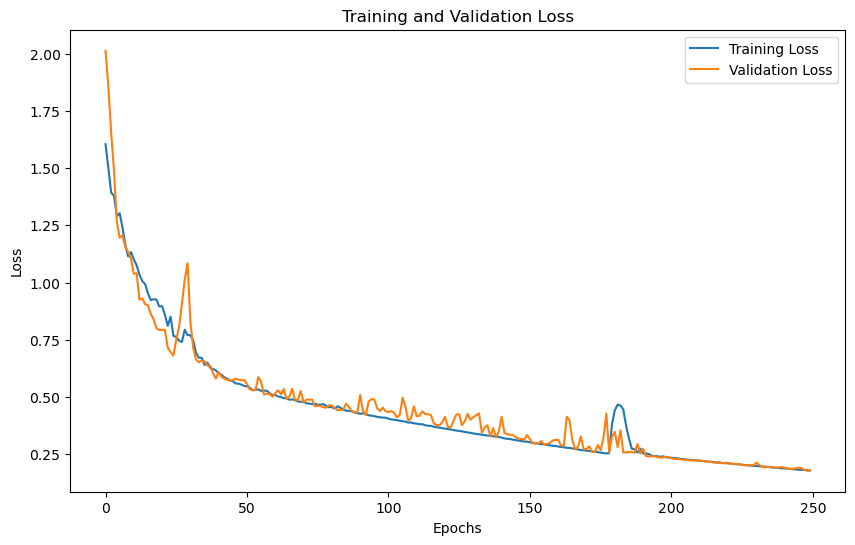

In [21]:
# Train the final model with the best hyperparameters
best_params = study.best_params

# weighted F1 best params
#best_params = {'epochs': 130, 'embed_dim': 128, 'num_heads': 8, 'ff_dim': 256, 'num_blocks': 1, 'dropout_rate': 0.35062671547806423, 'l2_reg': 0.00010345073760147071, 'learning_rate': 0.00024969942836710864}

# weighted F1 score (2)
#best_params = {'epochs': 250, 'embed_dim': 96, 'num_heads': 2, 'ff_dim': 192, 'dropout_rate': 0.45835328181947954, 'l2_reg': 0.0024359331830975796, 'learning_rate': 0.00040256894176205914}
#best_params = {'epochs': 100, 'embed_dim': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.5, 'l2_reg': 0.005, 'learning_rate': 0.0002}



# val loss best params
#best_params = {'epochs': 150, 'embed_dim': 64, 'num_heads': 2, 'ff_dim': 64, 'num_blocks': 1, 'dropout_rate': 0.15933730257169818, 'l2_reg': 0.0005640280350671932, 'learning_rate': 0.002881326189567326}

# Build the final model with fixed parameters
final_model = build_model(
    trial=optuna.trial.FixedTrial(best_params),  # Use fixed trial with best params
    input_shape=(X_train.shape[1], X_train.shape[2])
)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['epochs'],  # Use optimal number of epochs
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the model on the training, validation, and test sets
train_loss, train_accuracy = final_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = final_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)

# Predict to calculate F1 scores
y_train_pred = (final_model.predict(X_train) > 0.5).astype(int)
y_val_pred = (final_model.predict(X_val) > 0.5).astype(int)
y_test_pred = (final_model.predict(X_test) > 0.5).astype(int)

train_f1 = f1_score(y_train, y_train_pred, average="weighted")
val_f1 = f1_score(y_val, y_val_pred, average="weighted")
test_f1 = f1_score(y_test, y_test_pred, average="weighted")

# Print the final metrics
print(f"Final Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Weighted F1 Score: {train_f1:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Weighted F1 Score: {val_f1:.4f}")
print(f"Final Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Weighted F1 Score: {test_f1:.4f}")

# Plot the training and validation loss over all epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Save the plot to a file (e.g., PNG format)
plt.savefig("training_validation_loss_weightedf1scoreOptuna.png", dpi=300, bbox_inches='tight')  # Save with high resolution

# Display the plot
plt.show()



In [ ]:
# # Train the Transformer model
# # from tensorflow.keras.callbacks import EarlyStopping

# # early_stopping = EarlyStopping(
# #     monitor='val_loss',
# #     patience=50,
# #     restore_best_weights=True
# # )

# ## MAYBE TRY BRINGING BACK EARLY STOPPING BUT WITH A DIFFERENT PATIENCE 
# ## MAYBE TRY CLASS WEIGHTS 

# # Compute class weights to balance the dataset
# class_weights = compute_class_weight(
#     class_weight='balanced', 
#     classes=np.unique(y_train), 
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

# # lr_scheduler = ReduceLROnPlateau(
# #     monitor='val_loss',
# #     factor=0.5,  # Reduce the learning rate by half
# #     patience=5,  # Wait for 5 epochs without improvement
# #     min_lr=1e-6  # Minimum learning rate
# # )

# history = transformer_model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=70,
#     batch_size=16,
#     #callbacks=[early_stopping], # Trying bringing back early stopping or lr_scheduler
#     class_weight=class_weight_dict,
#     verbose=1
# )

# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

# # Print final training and validation accuracy
# print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
# print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

# # Evaluate the model on test data
# test_loss, test_accuracy = transformer_model.evaluate(X_test, y_test, verbose=1)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# # Get predictions
# y_pred = (transformer_model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, digits=4))

In [ ]:
# import matplotlib.pyplot as plt

# # Plot Training Loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# ## Trying to Find the Ideal Hyperparameters Using Grid Search


# # Define the model-building function
# def build_model(embed_dim, num_heads, ff_dim, num_blocks, l2_reg, dropout_rate):
#     inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
#     x = Dense(embed_dim, kernel_regularizer=l2(l2_reg))(inputs)
#     for _ in range(num_blocks):
#         x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate, regularizer=l2(l2_reg))(x, training=True)
#     x = GlobalAveragePooling1D()(x)
#     x = Dropout(dropout_rate)(x)
#     outputs = Dense(1, activation="sigmoid", kernel_regularizer=l2(l2_reg))(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Wrap the Keras model for GridSearchCV
# model = KerasClassifier(
#     model=build_model,
#     embed_dim=64,  # Default value, will be overridden by GridSearch
#     num_heads=4,
#     ff_dim=128,
#     num_blocks=2,
#     l2_reg=1e-3,
#     dropout_rate=0.3,
#     epochs=50,  # Use fewer epochs for tuning
#     batch_size=16,
#     verbose=0
# )

# # Define the parameter grid
# param_grid = {
#     'embed_dim': [32, 64, 128],
#     'num_heads': [2, 4, 6],
#     'ff_dim': [64, 128, 256],
#     'num_blocks': [1, 2, 3],
#     'l2_reg': [1e-3, 1e-4],
#     'dropout_rate': [0.1, 0.3, 0.5]
# }

# # Perform the grid search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)  # 3-fold cross-validation
# grid_result = grid.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters:", grid_result.best_params_)
# print("Best validation accuracy:", grid_result.best_score_)


In [ ]:
# import optuna
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling1D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2
# import tensorflow as tf

# # Define the Transformer-based model-building function
# def build_model(trial, input_shape):
#     # Suggest hyperparameters
#     embed_dim = trial.suggest_int("embed_dim", 32, 128, step=32)  # Embedding dimension
#     num_heads = trial.suggest_int("num_heads", 2, 8, step=2)      # Number of attention heads
#     ff_dim = trial.suggest_int("ff_dim", 64, 256, step=64)        # Feedforward network dimension
#     num_blocks = trial.suggest_int("num_blocks", 1, 3)            # Number of transformer blocks
#     dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
#     l2_reg = trial.suggest_loguniform("l2_reg", 1e-4, 1e-2)       # L2 regularization strength

#     # Input layer
#     inputs = Input(shape=input_shape)
    
#     # Dense embedding layer
#     x = Dense(embed_dim, kernel_regularizer=l2(l2_reg))(inputs)
    
#     # Add Transformer blocks
#     for _ in range(num_blocks):
#         x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate, regularizer=l2(l2_reg))(x, training=True)
    
#     # Global pooling and output layer
#     x = GlobalAveragePooling1D()(x)
#     x = Dropout(dropout_rate)(x)
#     outputs = Dense(1, activation="sigmoid", kernel_regularizer=l2(l2_reg))(x)
    
#     # Build and compile the model
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model



In [ ]:
# # Get the best hyperparameters
# #best_params = study.best_params

# best_params = {'epochs': 150, 'embed_dim': 128, 'num_heads': 8, 'ff_dim': 256, '
# num_blocks': 1, 'dropout_rate': 0.35062671547806423, 'l2_reg': 0.00010345073760147071, 'learning_rate': 0.00024969942836710864}

# # Build the final model using the best hyperparameters
# final_model = build_model(
#     trial=optuna.trial.FixedTrial(best_params),  # Use fixed trial with best params
#     input_shape=(X_train.shape[1], X_train.shape[2])
# )

# # Train the final model
# final_model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=500,  # Use full training time
#     batch_size=16,
#     verbose=1
# )

# # Evaluate on the test set
# test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [ ]:
### LSTM attempts - did not work

In [ ]:
# # Define function to normalize joint angles across all data
# def normalize_data(data_list):
#     """
#     Normalizes a list of numpy arrays using MinMax scaling across all features.
#     Arguments:
#         data_list: List of numpy arrays where each array corresponds to one time series.
#     Returns:
#         normalized_data: List of normalized numpy arrays.
#     """
#     # Flatten all data for joint normalization across the dataset
#     all_data = np.array(data_list)
    
#     # Apply MinMaxScaler
#     scaler = MinMaxScaler()
#     scaler.fit(all_data)  # Fit scaler on all joint angles across the dataset
    
#     # Normalize each time series
#     normalized_data = [scaler.transform(data) for data in data_list]
#     return normalized_data, scaler

# # Define function to pad time series to the same length
# def pad_time_series(data_list, max_length=None):
#     """
#     Pads all time series in data_list to the same length.
#     Arguments:
#         data_list: List of numpy arrays where each array corresponds to one time series.
#         max_length: If None, pad to the longest time series. Otherwise, pad to max_length.
#     Returns:
#         padded_data: Numpy array of shape (num_samples, max_length, num_features).
#     """
#     if max_length is None:
#         max_length = max(len(data) for data in data_list)  # Find the longest time series
#     padded_data = pad_sequences(data_list, maxlen=max_length, padding="post", dtype="float32")
#     return padded_data

In [ ]:
# def build_lstm_model_2(input_shape):
#     model = Sequential([
#         Masking(mask_value=0.0, input_shape=input_shape),  # Masking for padded values
#         LSTM(128, return_sequences=True),  # First LSTM layer with increased units
#         BatchNormalization(),  # Batch normalization to stabilize training
#         Dropout(0.2),  # Reduced dropout rate
#         LSTM(64, return_sequences=False),  # Second LSTM layer
#         BatchNormalization(),  # Batch normalization after second LSTM layer
#         Dropout(0.2),
#         Dense(32, activation='relu'),  # Increased fully connected layer size
#         Dense(1, activation='sigmoid')  # Output layer for binary classification
#     ])
#     model.compile(
#         optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

In [ ]:


# # Ensure consistent shuffling for reproducibility
# np.random.seed(42)

# def manual_train_val_test_split(data, labels, train_ratio=0.8, val_ratio=0.1):
#     """
#     Manually splits data and labels into training, validation, and testing sets with the given ratios.
#     Arguments:
#         data: Preprocessed time series data (numpy array).
#         labels: Corresponding labels (numpy array).
#         train_ratio: Proportion of data to use for training (default 0.7).
#         val_ratio: Proportion of data to use for validation (default 0.2).
#     Returns:
#         X_train, X_val, X_test, y_train, y_val, y_test: Split data and labels.
#     """
#     # Ensure train_ratio + val_ratio < 1
#     assert train_ratio + val_ratio < 1, "Train and validation ratios must sum to less than 1."
    
#     # Shuffle the indices
#     indices = np.arange(len(data))
#     np.random.shuffle(indices)
    
#     # Calculate the split points
#     train_split = int(len(data) * train_ratio)
#     val_split = int(len(data) * (train_ratio + val_ratio))
    
#     # Split the data and labels
#     train_indices = indices[:train_split]
#     val_indices = indices[train_split:val_split]
#     test_indices = indices[val_split:]
    
#     X_train = data[train_indices]
#     X_val = data[val_indices]
#     X_test = data[test_indices]
#     y_train = labels[train_indices]
#     y_val = labels[val_indices]
#     y_test = labels[test_indices]
    
#     return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
# Define LSTM model
# def build_lstm_model_1(input_shape):
#     model = Sequential([
#         Masking(mask_value=0.0, input_shape=input_shape),  # Masking for padded values
#         LSTM(64, return_sequences=True),  # First LSTM layer
#         Dropout(0.3),  # Dropout for regularization
#         LSTM(32),  # Second LSTM layer
#         Dropout(0.3),
#         Dense(16, activation='relu'),  # Fully connected layer
#         Dense(1, activation='sigmoid')  # Output layer for binary classification
#     ])
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model


In [ ]:
# ### Perform the manual train-test split
# # Call the function
# X_train, X_val, X_test, y_train, y_val, y_test = manual_train_val_test_split(
#     np.array(lstm_input), np.array(labels), train_ratio=0.8, val_ratio=0.1)
# # Check the shapes of the resulting datasets
# print("Training data shape:", X_train.shape)
# print("Training labels shape:", y_train.shape)
# print("Testing data shape:", X_test.shape)
# print("Testing labels shape:", y_test.shape)


# # Convert to numpy arrays
# X_train = np.array(X_train)
# X_val = np.array(X_val)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# y_test = np.array(y_test)

# # Define input shape (timepoints, features)
# input_shape = (X_train.shape[1], X_train.shape[2])

# # # Build model
# # model = build_lstm_model(input_shape)

# # # Train the model
# # history = model.fit(
# #     X_train, y_train,
# #     validation_data=(X_val, y_val),
# #     epochs=50,
# #     batch_size=16,
# #     verbose=1
# # )




In [ ]:
# TRY 3 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Define LSTM model with improvements
# def build_lstm_model(input_shape):
#     model = Sequential([
#         Masking(mask_value=0.0, input_shape=input_shape),  # Masking for padded values
#         LSTM(128, return_sequences=True),  # Increased units in the first LSTM layer
#         BatchNormalization(),  # Batch Normalization
#         Dropout(0.4),  # Increased Dropout for regularization
#         LSTM(64),  # Second LSTM layer with reduced units
#         BatchNormalization(),  # Batch Normalization
#         Dropout(0.4),
#         Dense(32, activation='relu'),  # Increased units in fully connected layer
#         Dropout(0.4),  # Additional dropout
#         Dense(1, activation='sigmoid')  # Output layer for binary classification
#     ])
#     model.compile(
#         optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Build the model
# input_shape = (X_train.shape[1], X_train.shape[2])  # Define input shape based on your data
# model = build_lstm_model(input_shape)

# # Compute class weights for handling class imbalance
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = dict(enumerate(class_weights))

# # Add EarlyStopping for regularization
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model with validation and early stopping
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=50,
#     batch_size=16,
#     class_weight=class_weights,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Evaluate the model on test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# # THE LATEST LSTM

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, BatchNormalization, Input
#from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# # Define the LSTM model
# def build_lstm_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         LSTM(256, return_sequences=True),  # Increase units
#         Dense(128, activation='relu'),  # Add a dense layer
#         LSTM(128, return_sequences=True),  # Second LSTM layer
#         Dense(64, activation='relu'),  # Add another dense layer
#         LSTM(64),  # Final LSTM layer
#         Dense(32, activation='relu'),  # Fully connected layer
#         Dense(1, activation='sigmoid')  # Output layer for binary classification
#     ])
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher LR
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, BatchNormalization
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# # Build an LSTM model optimized for overfitting to the training set
# def build_overfitting_lstm(input_shape):
#     model = Sequential([
#         Masking(mask_value=0.0, input_shape=input_shape),  # Masking padded values
#         LSTM(128, return_sequences=True, activation='relu'),  # First LSTM layer
#         LSTM(64, return_sequences=True, activation='relu'),   # Second LSTM layer
#         LSTM(32, activation='relu'),                         # Third LSTM layer
#         Dense(1, activation='sigmoid')                       # Output layer for binary classification
#     ])
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Train the model on training data only
# input_shape = (X_train.shape[1], X_train.shape[2])  # Define input shape from the training data
# model = build_overfitting_lstm(input_shape)

# # Train the model for an extended number of epochs
# history = model.fit(
#     X_train, y_train,
#     epochs=100,  # Increase epochs for training
#     batch_size=16,
#     verbose=1
# )

# # Plot training loss over epochs
# plt.plot(history.history['loss'], label='Train Loss')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import LearningRateScheduler

# def build_lstm_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         LSTM(256, return_sequences=True),  # Larger capacity
#         LSTM(128, return_sequences=True),
#         LSTM(128, return_sequences=True),
#         LSTM(64),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=Adam(learning_rate=0.0001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model


# # Build model
# input_shape = (X_train.shape[1], X_train.shape[2])  # Define input shape from the training data
# model = build_lstm_model(input_shape)


# # Train the model with class weights
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=500,
#     batch_size=16,
#     verbose=1
# )




In [ ]:
# import matplotlib.pyplot as plt

# # Extract the loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Print loss values for each epoch
# print("Training Loss per Epoch:")
# for epoch, loss in enumerate(train_loss):
#     print(f"Epoch {epoch+1}: Training Loss = {loss:.4f}, Validation Loss = {val_loss[epoch]:.4f}")

# # Plot the training and validation loss
# plt.figure(figsize=(8, 6))
# plt.plot(train_loss, label='Training Loss', marker='o')
# plt.plot(val_loss, label='Validation Loss', marker='o')
# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()
